***Create new features and analyse their significance in predicting the presence of West Nile Virus***

- 1. Create Weather Elements
    - 1.1 Feature Engineering Decisions
    - 1.2 Percentage of Traps with West Nile Virus Present in humid weather environment (dewpoint >= 60 )
    - 1.3 Percentage of traps with West Nile virus present in warm temperatures (temperature > 75)
    - 1.4 Percentage of traps with West Nile Virus in windy environment (avgspeed >=10)
    - 1.5 Percentage of traps with West Nile virus present in heavy rain (Precip_Total >=0.39)
    - 1.7 add Feature for Rainy days
- 2. Feature for Date/Time
- 3. Feature for Lat/Long
- 4. Create Dummies for Trap






In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import DBSCAN

In [2]:
#Load the datasets
df = pd.read_csv("../datasets/cleaned_traindf.csv")
df_test = pd.read_csv("../datasets/cleaned_testdf.csv")

In [3]:
df.describe(include="all")

,Date,Species,Block,Trap,Latitude,Longitude,WnvPresent,year,month,NumMosquitos,Tavg,DewPoint,PrecipTotal,SeaLevel,ResultSpeed,AvgSpeed,Sunrise,Sunset,CodeSum_set,Month
count,8610,8610,8610.000000,8610,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,4706,8610
unique,95,7,NaN,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,6
top,2007-08-01,CULEX PIPIENS/RESTUANS,NaN,T900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,'RA',August
freq,283,3899,NaN,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,943,2835
mean,NaN,NaN,38.793380,NaN,41.844422,-87.695237,0.053078,2009.713821,7.705459,15.683972,72.488734,59.303891,0.155266,29.961850,5.990569,7.502956,469.738328,1868.086992,NaN,NaN
std,NaN,NaN,24.129378,NaN,0.107076,0.084921,0.224202,2.338148,1.103277,68.560634,7.578527,7.949180,0.338199,0.119783,2.825564,2.487096,46.620449,65.110913,NaN,NaN
min,NaN,NaN,10.000000,NaN,41.644612,-87.930995,0.000000,2007.000000,5.000000,1.000000,51.000000,39.000000,0.000000,29.595000,0.600000,2.400000,416.000000,1720.000000,NaN,NaN
25%,NaN,NaN,14.000000,NaN,41.750498,-87.752411,0.000000,2007.000000,7.000000,2.000000,68.500000,54.000000,0.000000,29.880000,4.000000,5.800000,427.000000,1826.000000,NaN,NaN
50%,NaN,NaN,37.000000,NaN,41.857402,-87.694991,0.000000,2009.000000,8.000000,4.000000,73.500000,59.500000,0.000000,29.970000,5.700000,7.000000,451.000000,1904.000000,NaN,NaN
75%,NaN,NaN,58.000000,NaN,41.944869,-87.642984,0.000000,2011.000000,9.000000,11.000000,77.500000,66.500000,0.165000,30.050000,7.850000,9.350000,518.000000,1924.000000,NaN,NaN


## 1. Create Weather Elements

### 1.1 Feature Engineering Decisions
Creating new columns in determining where the weather (humid, hot temperature, windy, heavy rain) has any impact on West Nile Virus present in mosquitoes caught in traps. 

***Dew point is a better representative of the amount of moisture in the air. A dew point temperature below 60°F will feel comfortable for most of us and above 70°F we will feel sticky and makes us feel “hotter than it is out there.”*** [Reference](https://www.renesas.com/us/en/blogs/understanding-relative-humidity-and-dew-point)

 - is_humid = 1
    - dewpoint >= 60

 - is_humid = 0
    - dewpoint < 60 



***Rising temperatures could shift US West Nile virus transmission: New model suggests climate change may increase the areas in the US with optimal temperatures for West Nile virus transmission
West Nile virus spreads most efficiently in the US at temperatures between 24-25 degrees Celsius (75.2-77 degrees Fahrenheit), a new study shows.*** [Reference](https://www.sciencedaily.com/releases/2020/09/200915105932.htm#:~:text=West%20Nile%20virus%20spreads%20most,published%20today%20in%20eLife%20shows)

- is_hot = 1
    - temperature >= 75
- is_hot = 0
    - temperature < 75
    

***Wind works as a natural mosquito repellant because it makes it difficult for these insects to fly. If wind speeds are greater than 10 MPH, mosquitoes generally can’t fly. Keep in mind that they can only fly around 1-3 mph, so a 10 MPH wind gust is substantial.***[Reference](https://kestrelmeters.com/blogs/news/the-science-of-mosquito-abatement#:~:text=Wind%20works%20as%20a%20natural,MPH%20wind%20gust%20is%20substantial)
- is_windy = 1
    - AvgSpeed >= 10
- is_windy = 0
    - AvgSpeed <= 10

***Heavy rain — when the precipitation rate is > 7.6 mm (0.30 in) per hour,[106] or between 10 mm (0.39 in) and 50 mm (2.0 in) per hour*** [Reference](https://en.wikipedia.org/wiki/Rain#:~:text=Light%20rain%20%E2%80%94%20when%20the%20precipitation,50%20mm%20(2.0%20in)%20per)

- is_Heavy rain = 1
    - PrecipTotal >= 0.39
- is_Heavy rain  = 0
    - PrecipTotal < 0.39

In [4]:
def create_weather_elements (df):
    ''' function to add more fields related to weather'''

    df["is_humid"] = df.apply(lambda x: 0 if (x['DewPoint'] < 60)  else (1 if ((x['DewPoint'] >= 60)&(x['DewPoint'] < 75)) else 2), axis=1)
    df["is_veryhot"] = df['Tavg'].map(lambda x: 1 if x >= 70 else 0)
    df["is_wnvcarrier"] = df['Species'].map(lambda x:1 if ((x == "CULEX PIPIENS/RESTUANS") or (x=="CULEX PIPIENS") or (x=="CULEX RESTUANS")) else 0)
    df["is_windy"] = df['AvgSpeed'].map(lambda x: 1 if x >= 10 else 0)
    df["is_heavyrain"] = df.apply(lambda x: 0 if x['PrecipTotal'] < 0.39  else 1, axis=1)

In [5]:
create_weather_elements(df)

In [6]:
def line(row,col,n,x,xlabel,y,ylabel,color):
    plt.subplot(row,col,n)
    sns.lineplot(x=x, y=y, data=df, hue='WnvPresent')
    plt.ylabel(ylabel, fontsize=10, color=color)
    plt.xlabel(xlabel, fontsize=10)
    return

def scatter(row,col,n,x,xlabel,y,ylabel,color):
    plt.subplot(row,col,n)
    sns.scatterplot(x=x, y=y, data=df, hue='WnvPresent')
    plt.ylabel(ylabel, fontsize=10, color=color)
    plt.xlabel(xlabel, fontsize=10)
    return

def box(row,col,n,x,xlabel,y,ylabel,color):
    plt.subplot(row,col,n)
    sns.boxplot(x=x, y=y, data=df, hue='WnvPresent')
    plt.ylabel(ylabel, fontsize=10, color=color)
    plt.xlabel(xlabel, fontsize=10)
    return

def bar(row,col,n,x,xlabel,y,ylabel,color):
    plt.subplot(row,col,n)
    sns.barplot(x=x, y=y, data=df, hue='WnvPresent')
    plt.ylabel(ylabel, fontsize=10, color=color)
    plt.xlabel(xlabel, fontsize=10)
    return

In [7]:
df

,Date,Species,Block,Trap,Latitude,Longitude,WnvPresent,year,month,NumMosquitos,...,AvgSpeed,Sunrise,Sunset,CodeSum_set,Month,is_humid,is_veryhot,is_wnvcarrier,is_windy,is_heavyrain
0,2007-05-29,CULEX PIPIENS,22,T096,41.731922,-87.677512,0,2007,5,1,...,6.95,421,1917,"'HZ','BR'",May,0,1,1,0,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,0,2007,5,1,...,6.95,421,1917,"'HZ','BR'",May,0,1,1,0,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,T050,41.919343,-87.694259,0,2007,5,1,...,6.95,421,1917,"'HZ','BR'",May,0,1,1,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,T054,41.921965,-87.632085,0,2007,5,2,...,6.95,421,1917,"'HZ','BR'",May,0,1,1,0,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,0,2007,5,1,...,6.95,421,1917,"'HZ','BR'",May,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,CULEX RESTUANS,13,T209,41.740641,-87.546587,0,2013,9,1,...,4.40,543,1742,'BR',September,0,0,1,0,0
8606,2013-09-26,CULEX RESTUANS,40,T221,41.659112,-87.538693,0,2013,9,5,...,4.40,543,1742,'BR',September,0,0,1,0,0
8607,2013-09-26,CULEX RESTUANS,45,T220,41.963976,-87.691810,0,2013,9,8,...,4.40,543,1742,'BR',September,0,0,1,0,0
8608,2013-09-26,CULEX RESTUANS,50,T082,41.803423,-87.642984,0,2013,9,2,...,4.40,543,1742,'BR',September,0,0,1,0,0


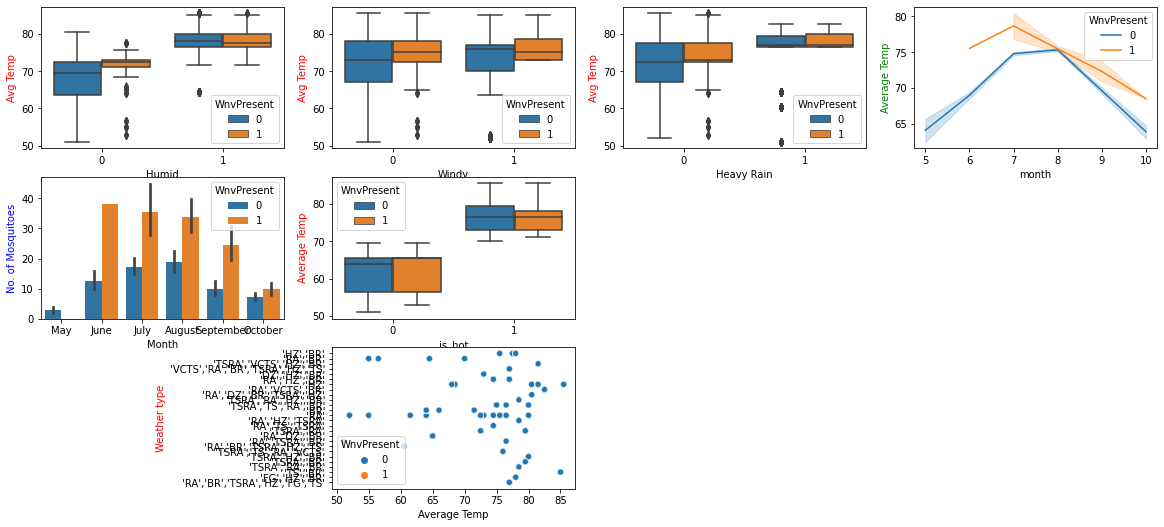

In [8]:
fig = plt.figure(figsize=(20,12))
box(4,4,1,'is_humid','Humid','Tavg','Avg Temp','red')
box(4,4,2,'is_windy','Windy','Tavg','Avg Temp','red')
box(4,4,3,'is_heavyrain','Heavy Rain','Tavg','Avg Temp','red')
line(4,4,4,'month','month','Tavg','Average Temp','Green')
bar(4,4,5, 'Month', 'Month','NumMosquitos','No. of Mosquitoes', 'blue')
box(4,4,6,'is_veryhot','is_hot','Tavg','Average Temp','red')
scatter(4,4,10,'Tavg','Average Temp','CodeSum_set','Weather type','red')


heavy rain will have higher temperature??? --> https://phys.org/news/2018-05-higher-temperature-heavier.html (Yes! the higher the temperature, rain intensity increases by seven percent for every degree Celsius of temperature rise)





### 1.2 Percentage of Traps with West Nile Virus Present in humid weather environment (dewpoint >= 60 )

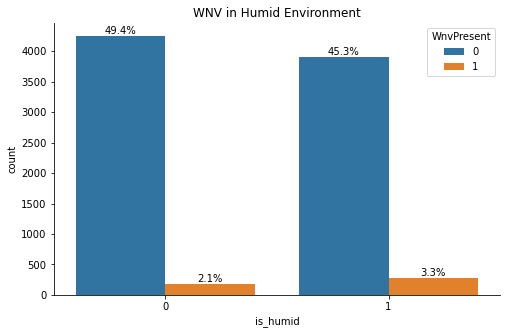

In [9]:
ncount = len(df)

plt.figure(figsize=(8,5))

plt.title("WNV in Humid Environment") #please change the title
ax = sns.countplot(data = df, x = 'is_humid', hue = 'WnvPresent')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

sns.despine()

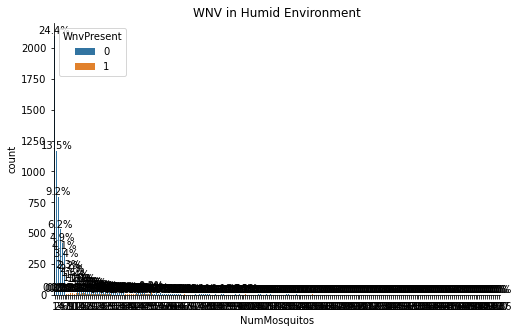

In [10]:
ncount = len(df)

plt.figure(figsize=(8,5))

plt.title("WNV in Humid Environment") #please change the title
ax = sns.countplot(data = df, x = 'NumMosquitos', hue = 'WnvPresent')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

sns.despine()

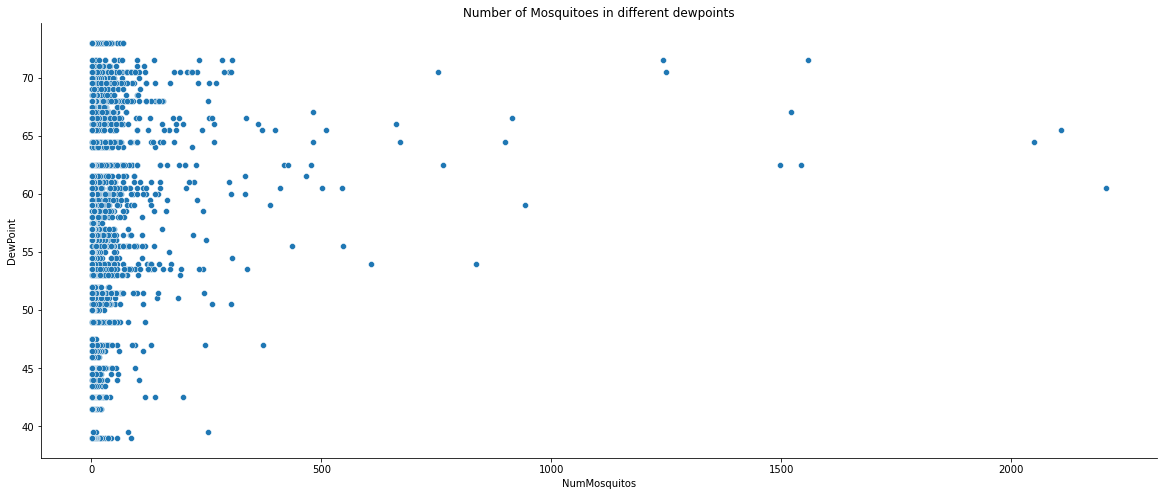

In [11]:
plt.figure(figsize=(20,8))

plt.title("Number of Mosquitoes in different dewpoints") #please change the title
ax = sns.scatterplot(data = df, x = "NumMosquitos", y='DewPoint')
sns.despine()

Number of mosquitoes are much higher at dew points higher than 60.

### 1.3 Percentage of traps with West Nile virus present in warm temperatures (temperature >=65)

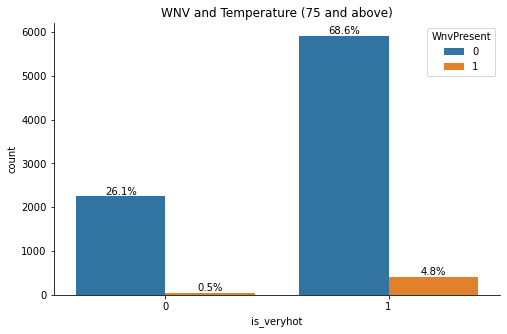

In [12]:
plt.figure(figsize=(8,5))

plt.title("WNV and Temperature (75 and above)") #please change the title
ax = sns.countplot(data = df, x = 'is_veryhot', hue = 'WnvPresent')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

sns.despine()

Presence of WNV has significantly high values for ***Hot*** environment (Average Temperature > 65 )

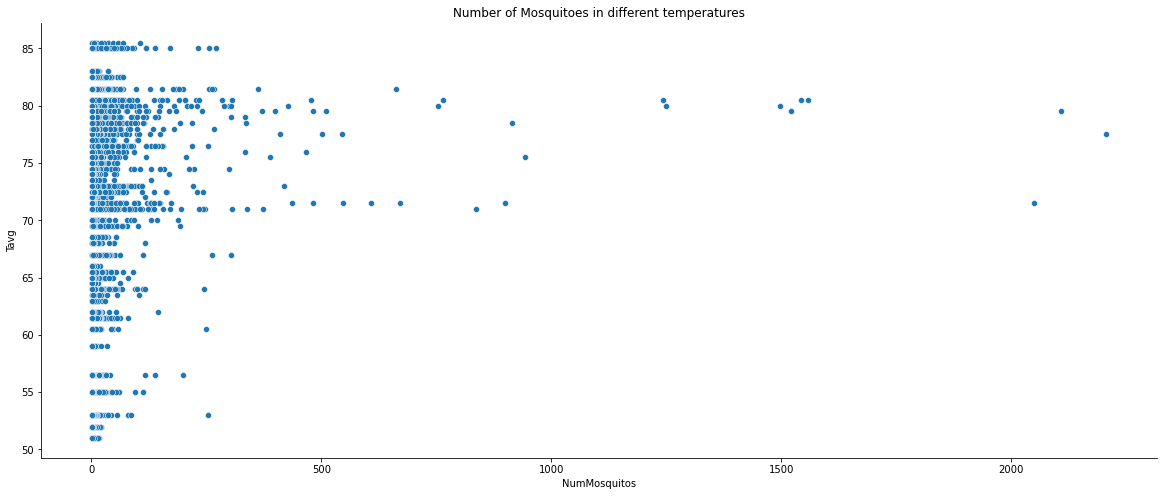

In [13]:
plt.figure(figsize=(20,8))

plt.title("Number of Mosquitoes in different temperatures") #please change the title
ax = sns.scatterplot(data = df, x = "NumMosquitos", y='Tavg')
sns.despine()

Number of mosquitoes are much higher in temperatures higher than 70 Fahrenheit.

### 1.4 Percentage of traps with West Nile Virus in windy environment (avgspeed >=10.5)

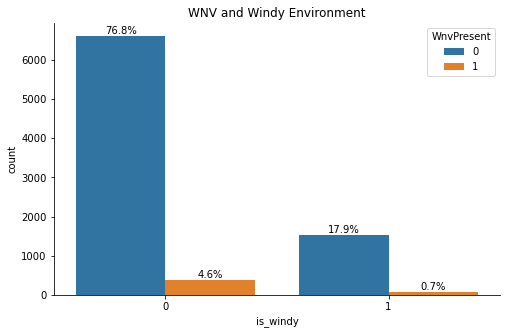

In [14]:
plt.figure(figsize=(8,5))

plt.title("WNV and Windy Environment") #please change the title

ax = sns.countplot(data = df, x = 'is_windy', hue = 'WnvPresent')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

sns.despine()

Presence of WNV has significantly high values if it is ***Not Windy*** (AvgSpeed < 10.5)

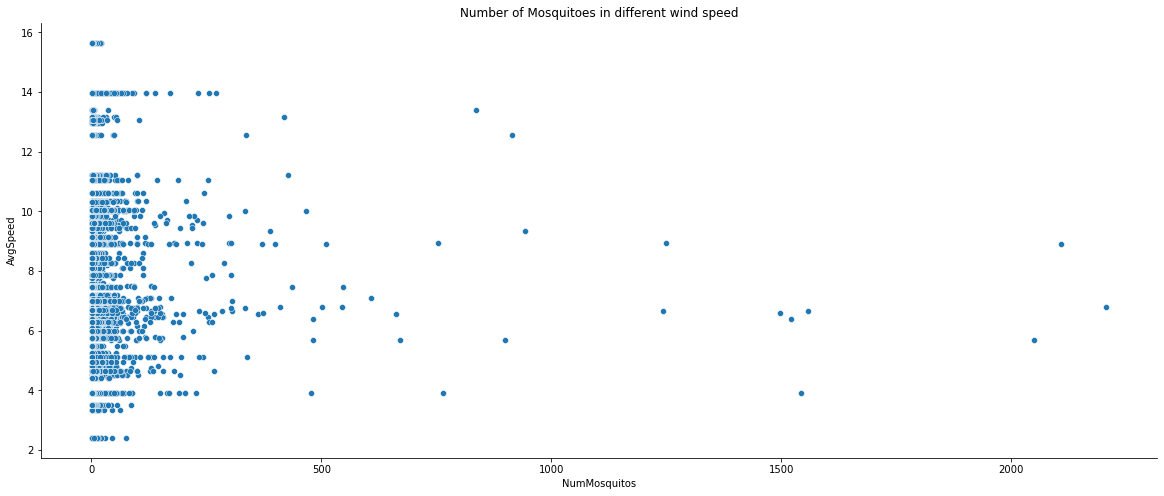

In [15]:
plt.figure(figsize=(20,8))

plt.title("Number of Mosquitoes in different wind speed") #please change the title
ax = sns.scatterplot(data = df, x = "NumMosquitos", y='AvgSpeed')
sns.despine()

Number of mosquitoes are much higher at wind speed below 10.

### 1.5 Percentage of traps with West Nile virus present in heavy rain (Precip_Total >=0.39)

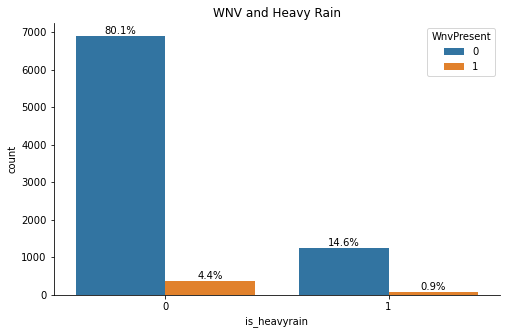

In [16]:
plt.figure(figsize=(8,5))

plt.title("WNV and Heavy Rain") #please change the title

ax = sns.countplot(data = df, x = 'is_heavyrain', hue = 'WnvPresent')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

sns.despine()

Presence of WNV has significantly high values if it is ***Not Heavy Rain*** (PrecipTotal < 0.39)

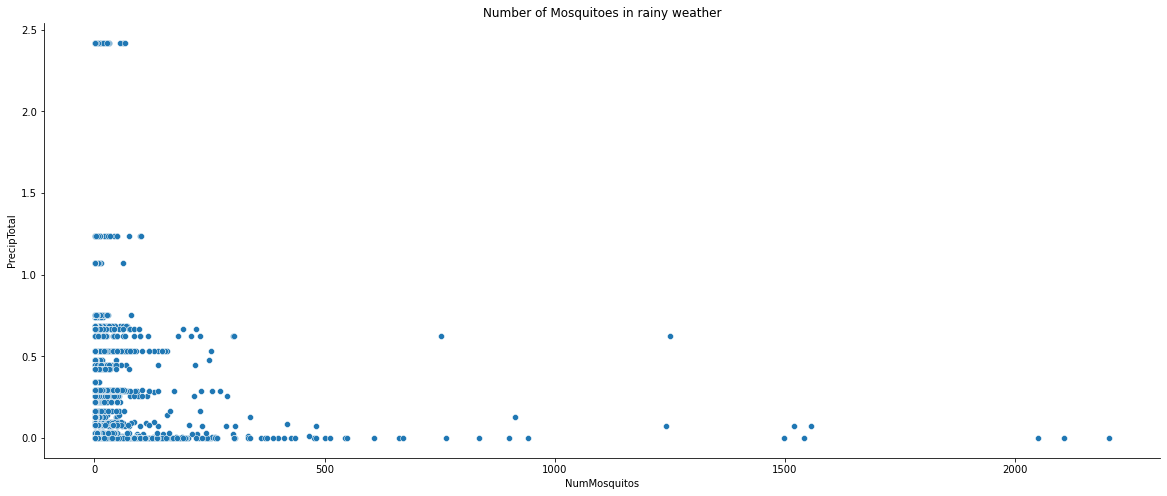

In [17]:
plt.figure(figsize=(20,8))

plt.title("Number of Mosquitoes in rainy weather") #please change the title
ax = sns.scatterplot(data = df, x = "NumMosquitos", y='PrecipTotal')
sns.despine()

Number of mosquitoes decrease dramatically when PrecipTotal is higher than 1.25.

### 1.7 Add Feature for Rainy days

When we looked at the PrecipTotal, the presence of WNV is low, but it peaks around 30 days after the heavy rain. Reason could be the water can stuck and hence breed more mosquito.

In [18]:
year = [2007,2009,2011,2013]

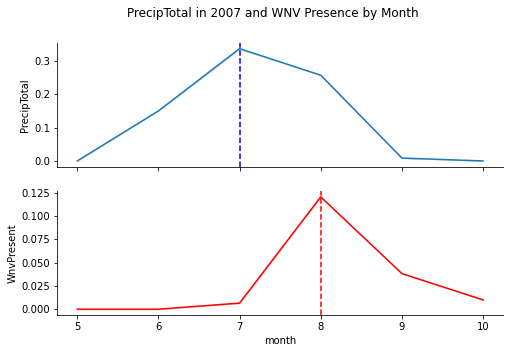

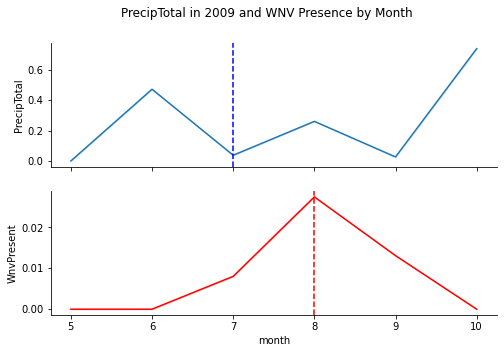

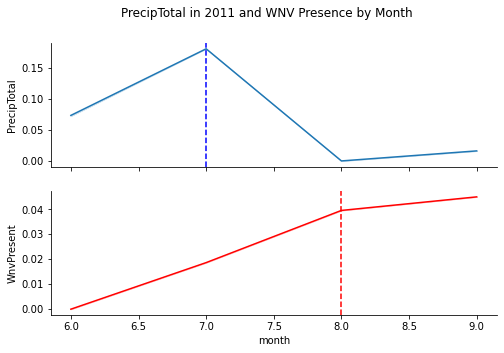

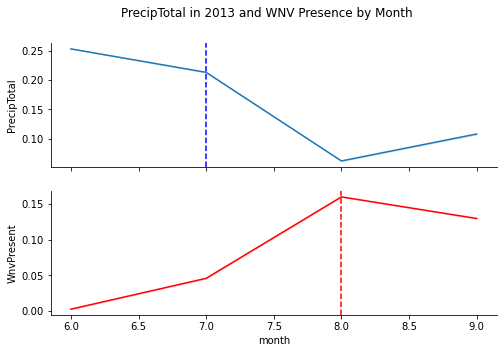

In [19]:
#Pattern shows heavy rain in month 7(Jul), WNV peak in month 8(Aug) -- except for 2009

for y in year:
 
    fig, axs = plt.subplots(nrows=2,ncols=1 ,sharex=True, figsize=(8,5))

    fig.suptitle(f'PrecipTotal in {y} and WNV Presence by Month')

    df_yr = df[df["year"]==y]
    sns.lineplot(data=df_yr, x='month', y='PrecipTotal', ax= axs[0], ci=False)
    axs[0].axvline(x= 7 , color='blue', ls='--')

    sns.lineplot(data=df_yr, x='month', y='WnvPresent', ax= axs[1], ci=False, color = 'red')
    axs[1].axvline(x= 8 , color='red', ls='--')

    sns.despine()

    #plt.savefig(f'/datasets/wnv_{y}.png', bbox_inches='tight')
    #plt.close(fig);

In [4]:
#we need to use the weather dataset, as the df has duplicate dates
df_weather= pd.read_csv("../datasets/cleaned_weather.csv")

In [5]:
df_weather.shape

(1472, 15)

In [22]:
#select only fields that we need
df_weather = df_weather[['Date', 'Sunset', 'Sunrise', 'DewPoint', 'PrecipTotal', 'Tavg', 'AvgSpeed']].copy()

In [23]:
#add relative humidity
def relhumid(df):
    t = (df['Tavg'] - 32)*(5/9)
    td =(df['DewPoint'] - 32)*(5/9)
    es = 6.11*(10*((7.5*t)/(237.3+t)))
    e = 6.11*(10*((7.5*td)/(237.3+td)))

    return (e/es)*100  

In [24]:
df_weather['RelHumid'] = df_weather.apply(relhumid, axis=1)

In [25]:
#Need to set the Date as index for rolling window calculation
df_weather['Date'] = pd.to_datetime(df_weather['Date'] )
df_weather.set_index(keys='Date', inplace=True)
df_weather.head()

,Sunset,Sunrise,DewPoint,PrecipTotal,Tavg,AvgSpeed,RelHumid
Date,,,,,,,
2007-05-01,1849,448,51.0,0.0,67.5,9.40,55.500547
2007-05-02,1850,447,42.0,0.0,51.5,13.40,52.396521
2007-05-03,1851,446,40.0,0.0,57.0,12.55,33.250172
2007-05-04,1852,444,41.5,0.0,58.0,10.60,37.919198
2007-05-05,1853,443,38.5,0.0,60.0,11.75,24.365257


In [26]:
#get the mean of the rolling days for Tavg, AvgSpeed, PrecipTotal and RelHumid
for feature in ['Tavg', 'AvgSpeed', 'PrecipTotal', 'RelHumid']:
    for day in [7, 15, 30]:
        df_weather[(feature + '_roll_' + str(day))] = df_weather[feature].rolling(day).mean()

In [27]:
#check if heavy rain and tag if the rain happened in x number of days ago
df_weather["is_heavyrain"] = df_weather.apply(lambda x: 0 if x['PrecipTotal'] < 0.39  else 1, axis=1)

for i in [7,15,30]: 
    df_weather["heavyrain" + '_past_' + str(i)] = df_weather["is_heavyrain"].rolling(window=i).max()

df_weather = df_weather.fillna(0)

In [31]:
df_weather['total_sunlight'] = df_weather['Sunset'] - df_weather['Sunrise']

In [32]:
df_weather.drop(columns=['Sunset', 'Sunrise', 'DewPoint', 'PrecipTotal', 'AvgSpeed', 'Tavg'], inplace=True)

In [33]:
df_weather.dtypes

RelHumid               float64
Tavg_roll_7            float64
Tavg_roll_15           float64
Tavg_roll_30           float64
AvgSpeed_roll_7        float64
AvgSpeed_roll_15       float64
AvgSpeed_roll_30       float64
PrecipTotal_roll_7     float64
PrecipTotal_roll_15    float64
PrecipTotal_roll_30    float64
RelHumid_roll_7        float64
RelHumid_roll_15       float64
RelHumid_roll_30       float64
is_heavyrain             int64
heavyrain_past_7       float64
heavyrain_past_15      float64
heavyrain_past_30      float64
total_sunlight           int64
dtype: object

In [34]:
#reset index to join with train dataset later
df_weather.reset_index()
df["Date"] = pd.to_datetime(df['Date'])
df = pd.merge(left=df, right=df_weather, how="left", on="Date")

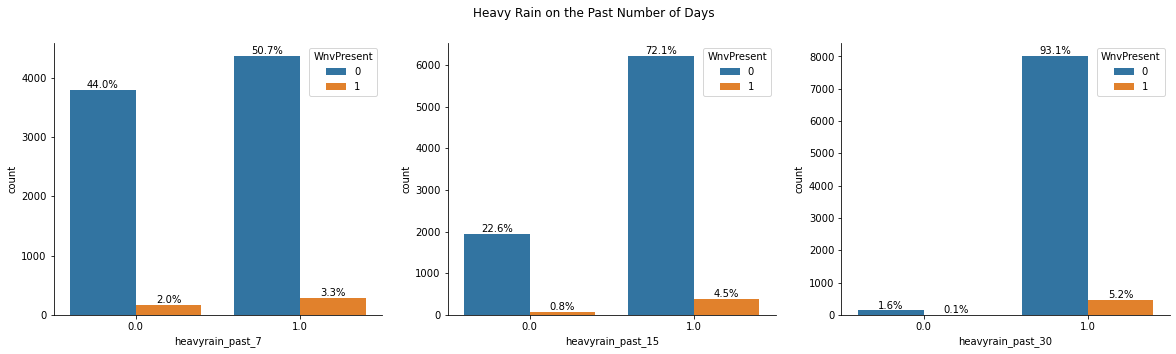

In [35]:
fig, axs = plt.subplots(nrows=1,ncols=3 ,sharex=True, figsize=(20,5))

fig.suptitle(f'Heavy Rain on the Past Number of Days')

ax = sns.countplot(data = df, x = 'heavyrain_past_7', hue = 'WnvPresent', ax=axs[0])

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text


ax = sns.countplot(data = df, x = 'heavyrain_past_15', hue = 'WnvPresent', ax=axs[1])

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

ax = sns.countplot(data = df, x = 'heavyrain_past_30', hue = 'WnvPresent', ax=axs[2])

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.0 * (y/ncount)), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

sns.despine()

## 2. Feature for Date/Time

In [36]:
#get the date of the year where there's peak of mosquito
df['day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear
max_day_of_year = df.groupby('day_of_year')['WnvPresent'].sum().idxmax()
print(max_day_of_year)

227


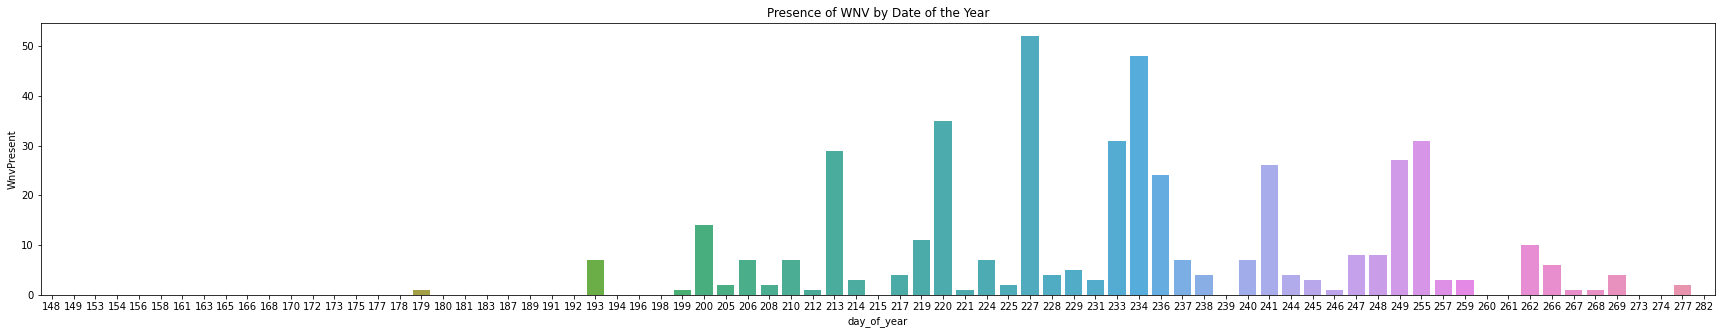

In [37]:
#Visualize the peak
plt.figure(figsize=(30,5))
plt.title("Presence of WNV by Date of the Year")
ax = sns.barplot(data = df, x = 'day_of_year', y = 'WnvPresent',ci=None,estimator=sum)



In [38]:
def calculate_day_from_max_day(df):
    df['day_from_max_wnv'] = abs(max_day_of_year - df['day_of_year'])

    return df


#implement for train 
df = calculate_day_from_max_day(df)


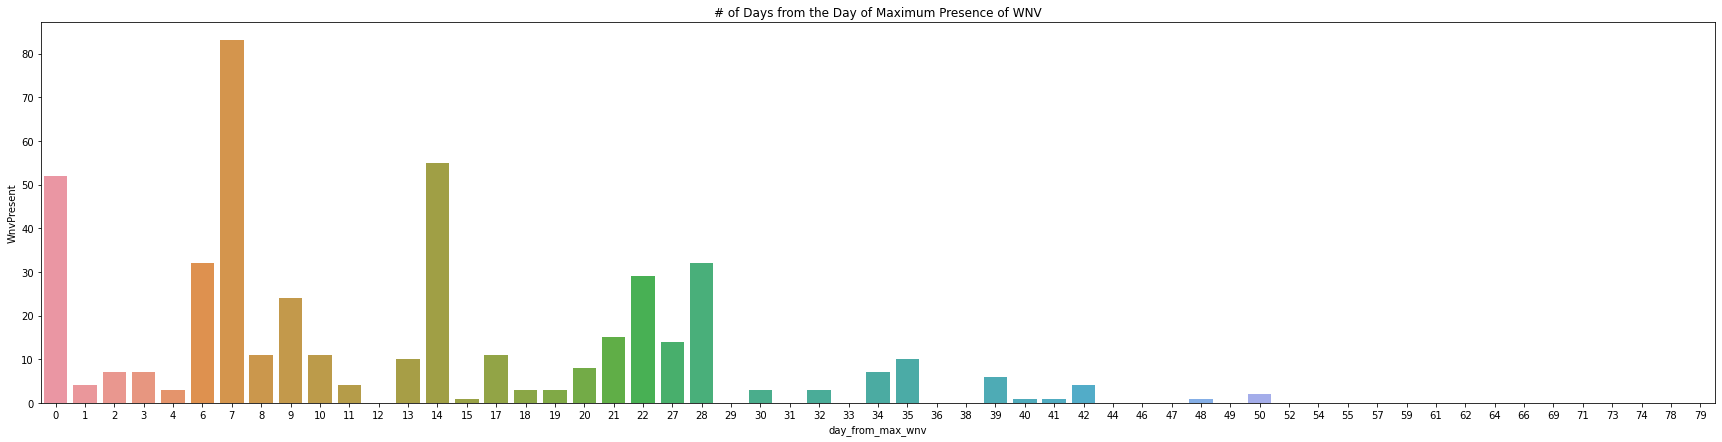

In [39]:
plt.figure(figsize=(30,7))

plt.title('# of Days from the Day of Maximum Presence of WNV')
ax = sns.barplot(data = df, x = 'day_from_max_wnv', y = 'WnvPresent',ci=None,estimator=sum)

The nearer to the day from the maximum presence of WNV, the higher the WNV presence is recorded. The last +-30 days have hte most recorded presence of WNV (out of 365 days)

## 3. Feature for Lat/Long

This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points

Ref: https://www.movable-type.co.uk/scripts/latlong.html

In [40]:
#Reference: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))

    return h

In [41]:
#Reference: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

In [42]:
#create cluster and identify hotspots (sample code... WORK IN PRogress, not final :D)
#maybe can create KNN cluster???

def dbs_cluster(df):
    latlong = df[['Latitude', 'Longitude']] 
    dbs = DBSCAN(eps=.01, min_samples=5).fit(latlong) 
    #print(dbs.core_sample_indices_)
    return dbs.labels_ 

In [43]:
#manually check the cluster location with maximum presence of WNV

df["label"] = dbs_cluster(df)


#should i get mean() of the latitude/longitude?
df.groupby('label').agg({"Latitude":"mean","Longitude":"mean",
                        "WnvPresent":"sum"}).sort_values(by="WnvPresent", ascending=False)


,Latitude,Longitude,WnvPresent
label,,,
94,41.974689,-87.890615,29
84,41.673408,-87.599862,15
5,41.954690,-87.800991,15
25,41.963761,-87.757229,14
98,41.743402,-87.731435,11
...,...,...,...
23,41.954630,-87.700799,0
8,42.017430,-87.687769,0
6,41.891126,-87.611560,0


In [44]:
# create list of hotspot clusters  from top 4 above
hotspots = {'wvn_1':(41.974689, -87.890615), 'wvn_2':(41.95469, -87.800991), 
    'wvn_3':(41.673408, -87.599862), 'wvn_4':(41.961743, -87.748367)}


#cleanup the temporary feature for clustering
df.drop(columns="label", inplace=True)

In [45]:
def add_distances_from_hotspot(df):

    for name, loc in hotspots.items():
        #print(name, loc)
    
        df['haversine_' + name] = haversine_array(df["Latitude"], df['Longitude'],
                                loc[0], loc[1]   #this is Lat/Long from hotspot list
                                )

        df['bearing_' + name] = bearing_array(df["Latitude"], df['Longitude'],
                                loc[0], loc[1]   #this is Lat/Long from hotspot list
                                )
    
    return df

In [46]:
def min_distance(df):

    df["haversine_min"] = np.min([df["haversine_wvn_1"], df["haversine_wvn_2"], df["haversine_wvn_3"], df["haversine_wvn_4"]])
    df["bearing_min"] = np.min([df["bearing_wvn_1"], df["bearing_wvn_2"], df["bearing_wvn_3"], df["bearing_wvn_4"]])

    return df

In [47]:
df = add_distances_from_hotspot(df)
df = df.apply(min_distance, axis=1)

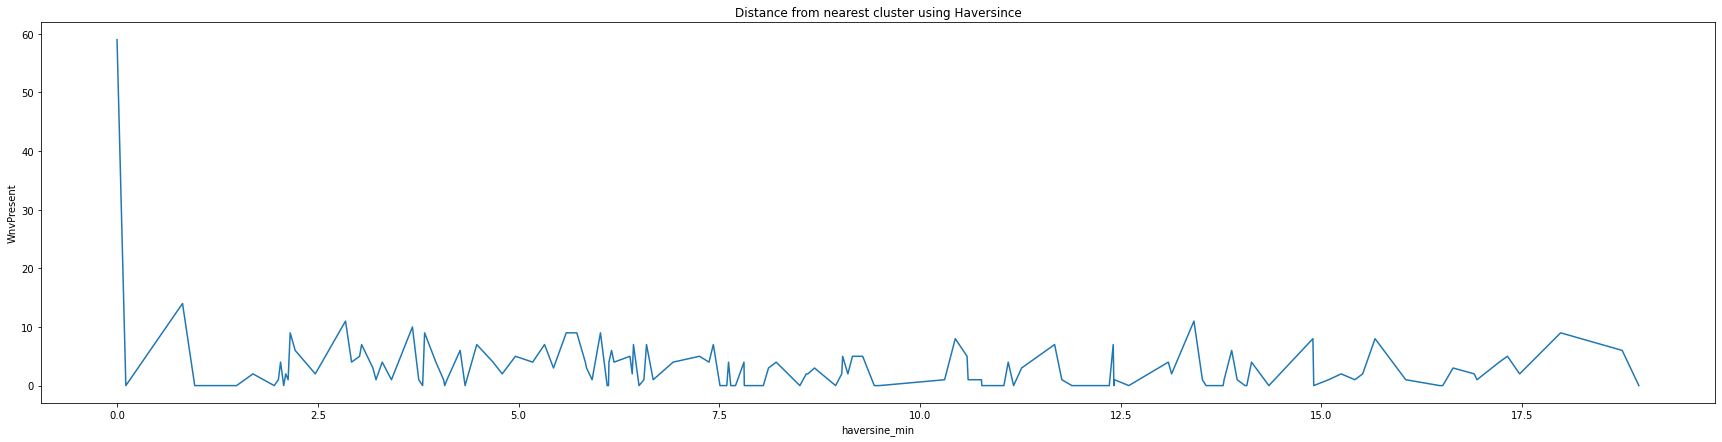

In [48]:
#visualize
plt.figure(figsize=(30,7))

plt.title('Distance from nearest cluster using Haversince')
ax = sns.lineplot(data = df, x = 'haversine_min', y = 'WnvPresent',ci=None,estimator=sum)

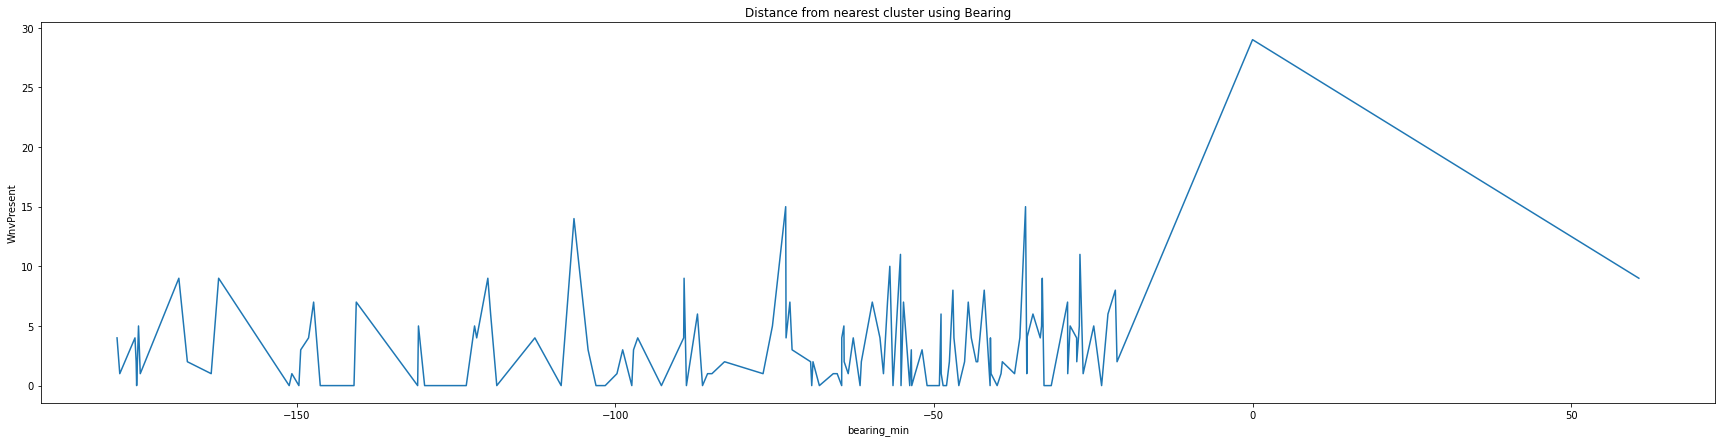

In [49]:
#visualize
plt.figure(figsize=(30,7))

plt.title('Distance from nearest cluster using Bearing')
ax = sns.lineplot(data = df, x = 'bearing_min', y = 'WnvPresent',ci=None,estimator=sum)

In [50]:
df_spray= pd.read_csv("../datasets/cleaned_spray.csv")

In [51]:
df_spray['Date'] = pd.to_datetime(df_spray['Date'])
df_spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


## 4. Effectiveness of spraying for WnV carriers in 2011 and 2013


In [52]:
spray_2011 = df_spray[df_spray['Date'].dt.year == 2011]
spray_2013 = df_spray[df_spray['Date'].dt.year == 2013]

In [53]:
spray_2011dates = spray_2011['Date'].unique()[:2]
NumMos_2011 = df[df['Date'].dt.year==2011].groupby('Date')['NumMosquitos'].sum()
wnvcarrier_2011 = df[df['Date'].dt.year==2011].groupby('Date')['is_wnvcarrier'].sum()


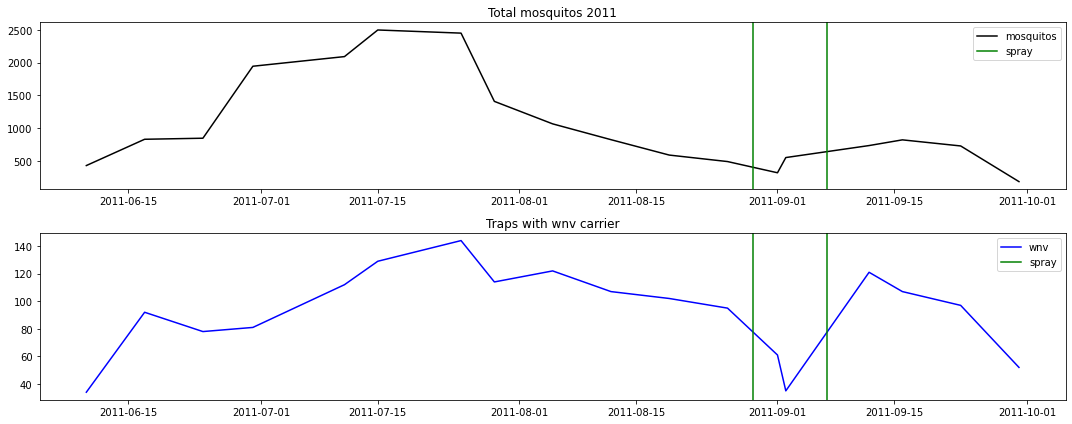

In [54]:
fig, ax = plt.subplots(nrows=2, figsize=(15,6))
ax[0].plot(NumMos_2011.index, NumMos_2011.values, color='black')
for Date in spray_2011dates:
    ax[0].axvline(x= Date, color='green', ls='-')
ax[0].set_title('Total mosquitos 2011')
ax[0].legend(['mosquitos','spray'], loc='upper right')


ax[1].plot(wnvcarrier_2011.index,wnvcarrier_2011.values,color='blue')
for Date in spray_2011dates:
    ax[1].axvline(x= Date, color='green', ls='-')
ax[1].set_title('Traps with wnv carrier')
ax[1].legend(['wnv','spray'], loc='upper right')


plt.tight_layout()

In [55]:
spray_2013dates = spray_2013['Date'].unique()[:8]
NumMos_2013 = df[df['Date'].dt.year==2013].groupby('Date')['NumMosquitos'].sum()
wnvcarrier_2013 = df[df['Date'].dt.year==2013].groupby('Date')['is_wnvcarrier'].sum()



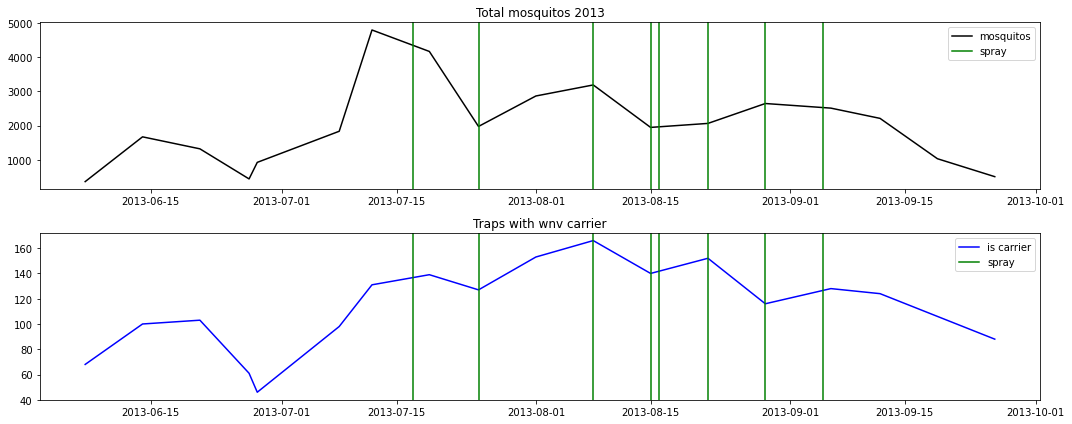

In [56]:
fig, ax = plt.subplots(nrows=2, figsize=(15,6))
ax[0].plot(NumMos_2013.index, NumMos_2013.values, color='black')
for Date in spray_2013dates:
    ax[0].axvline(x= Date, color='green', ls='-')
ax[0].set_title('Total mosquitos 2013')
ax[0].legend(['mosquitos','spray'], loc='upper right')


ax[1].plot(wnvcarrier_2013.index,wnvcarrier_2013.values,color='blue')
for Date in spray_2013dates:
    ax[1].axvline(x= Date, color='green', ls='-')
ax[1].set_title('Traps with wnv carrier')
ax[1].legend(['is carrier','spray'], loc='upper right')


plt.tight_layout()

Initial assumption was that spray is an effective substance to kill mosquitoes as well as reducing the cases of WNV.
However, based on the graphs above, it is inconclusive whether the spray data is effective in 2011 and 2013. It was observed that the number of mosquitoes fluctuate consistently after the sprays. Sometimes, the number of mosquitoes increase, other times, the number decreases. Similarly with the counts of traps with wnv carriers, no trend was noticed whether the sprays can decrease the count of wnv carrier. 

## 5. Create Dummies -- should be the last step

Create Dummy for Species and Trap. 
Concat Train/Test Dataset first to get the complete set of fields and to be consistent, then split later to train and test

In [57]:
##add weather elements to the df_test too
create_weather_elements(df_test)

#add rolling window for heavy rain
df_test["Date"] = pd.to_datetime(df_test['Date'])
df_test = pd.merge(left=df_test, right=df_weather, how="left", on="Date")

#add number of days from the MAX day_of_year with highest presence of WNV
df_test['day_of_year'] = pd.to_datetime(df_test['Date']).dt.dayofyear
df_test = calculate_day_from_max_day(df_test)

#calculate distance from hotspot
df_test = add_distances_from_hotspot(df_test)
df_test = df_test.apply(min_distance, axis=1)

In [58]:
#drop the fields WnvPresent, NumMosquitos in train as they are not in test
#Month as well as it seems to be duplicated
#haversince and bearing columsn used to calculate the min ditance to the clusters can be dropped  as wells
df.drop(columns=['NumMosquitos', 'Month', "haversine_wvn_1", "haversine_wvn_2", "haversine_wvn_3", "haversine_wvn_4", "bearing_wvn_1", "bearing_wvn_2", "bearing_wvn_3", "bearing_wvn_4"], inplace=True)
df_test.drop(columns=['Month',"haversine_wvn_1", "haversine_wvn_2", "haversine_wvn_3", "haversine_wvn_4", "bearing_wvn_1", "bearing_wvn_2", "bearing_wvn_3", "bearing_wvn_4"], inplace=True)

In [60]:
#tagged the fields before concatenating
df_test['source'] = 'Test'
df_test.insert(6, 'WnvPresent', 0) #dummy  field

df.insert(0, 'Id', 0) #dummy ID field
df['source'] = 'Train'

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   8610 non-null   int64         
 1   Date                 8610 non-null   datetime64[ns]
 2   Species              8610 non-null   object        
 3   Block                8610 non-null   int64         
 4   Trap                 8610 non-null   object        
 5   Latitude             8610 non-null   float64       
 6   Longitude            8610 non-null   float64       
 7   WnvPresent           8610 non-null   int64         
 8   year                 8610 non-null   int64         
 9   month                8610 non-null   int64         
 10  Tavg                 8610 non-null   float64       
 11  DewPoint             8610 non-null   float64       
 12  PrecipTotal          8610 non-null   float64       
 13  SeaLevel             8610 non-nul

In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Id                   116293 non-null  int64         
 1   Date                 116293 non-null  datetime64[ns]
 2   Species              116293 non-null  object        
 3   Block                116293 non-null  int64         
 4   Trap                 116293 non-null  object        
 5   Latitude             116293 non-null  float64       
 6   WnvPresent           116293 non-null  int64         
 7   Longitude            116293 non-null  float64       
 8   year                 116293 non-null  int64         
 9   month                116293 non-null  int64         
 10  Tavg                 116293 non-null  float64       
 11  DewPoint             116293 non-null  float64       
 12  PrecipTotal          116293 non-null  float64       
 13  SeaLevel      

In [62]:
df_test

,Id,Date,Species,Block,Trap,Latitude,WnvPresent,Longitude,year,month,...,is_heavyrain_y,heavyrain_past_7,heavyrain_past_15,heavyrain_past_30,total_sunlight,day_of_year,day_from_max_wnv,haversine_min,bearing_min,source
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41,T002,41.954690,0,-87.800991,2008,6,...,0,1.0,1.0,1.0,1510,163,64,0.000000,-73.265405,Test
1,2,2008-06-11,CULEX RESTUANS,41,T002,41.954690,0,-87.800991,2008,6,...,0,1.0,1.0,1.0,1510,163,64,0.000000,-73.265405,Test
2,3,2008-06-11,CULEX PIPIENS,41,T002,41.954690,0,-87.800991,2008,6,...,0,1.0,1.0,1.0,1510,163,64,0.000000,-73.265405,Test
3,4,2008-06-11,CULEX SALINARIUS,41,T002,41.954690,0,-87.800991,2008,6,...,0,1.0,1.0,1.0,1510,163,64,0.000000,-73.265405,Test
4,5,2008-06-11,CULEX TERRITANS,41,T002,41.954690,0,-87.800991,2008,6,...,0,1.0,1.0,1.0,1510,163,64,0.000000,-73.265405,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,21,T054C,41.925652,0,-87.633590,2014,10,...,1,1.0,1.0,1.0,1183,275,48,10.306293,-76.817327,Test
116289,116290,2014-10-02,CULEX TERRITANS,21,T054C,41.925652,0,-87.633590,2014,10,...,1,1.0,1.0,1.0,1183,275,48,10.306293,-76.817327,Test
116290,116291,2014-10-02,CULEX TARSALIS,21,T054C,41.925652,0,-87.633590,2014,10,...,1,1.0,1.0,1.0,1183,275,48,10.306293,-76.817327,Test
116291,116292,2014-10-02,UNSPECIFIED CULEX,21,T054C,41.925652,0,-87.633590,2014,10,...,1,1.0,1.0,1.0,1183,275,48,10.306293,-76.817327,Test


In [63]:
#now they have the same data, concatenate and create dummies

df_concat = pd.concat([df, df_test])
df_concat.shape

(124903, 47)

In [64]:
#add one more field for the day

df_concat['day'] = pd.to_datetime(df_concat["Date"]).dt.day
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124903 entries, 0 to 116292
Data columns (total 48 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Id                   124903 non-null  int64         
 1   Date                 124903 non-null  datetime64[ns]
 2   Species              124903 non-null  object        
 3   Block                124903 non-null  int64         
 4   Trap                 124903 non-null  object        
 5   Latitude             124903 non-null  float64       
 6   Longitude            124903 non-null  float64       
 7   WnvPresent           124903 non-null  int64         
 8   year                 124903 non-null  int64         
 9   month                124903 non-null  int64         
 10  Tavg                 124903 non-null  float64       
 11  DewPoint             124903 non-null  float64       
 12  PrecipTotal          124903 non-null  float64       
 13  SeaLevel      

In [65]:
#Create dummies for Codesum
cs_dummy = df_concat['CodeSum_set'].str.get_dummies( sep=',')
cs_dummy

,'BCFG','BR','DZ','FG','FG+','HZ','RA','TS','TSRA','VCTS'
0,0,1,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
116288,0,1,0,0,0,0,1,0,1,0
116289,0,1,0,0,0,0,1,0,1,0
116290,0,1,0,0,0,0,1,0,1,0
116291,0,1,0,0,0,0,1,0,1,0


In [66]:

#create dummies for Species and Trap
df_dummy = pd.get_dummies(df_concat['Trap'], drop_first=True)
df_concat = pd.concat([df_concat, df_dummy, cs_dummy], axis=1)


In [68]:
df_concat

,Id,Date,Species,Block,Trap,Latitude,Longitude,WnvPresent,year,month,...,'BCFG','BR','DZ','FG','FG+','HZ','RA','TS','TSRA','VCTS'
0,0,2007-05-29,CULEX PIPIENS,22,T096,41.731922,-87.677512,0,2007,5,...,0,1,0,0,0,1,0,0,0,0
1,0,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,0,2007,5,...,0,1,0,0,0,1,0,0,0,0
2,0,2007-05-29,CULEX PIPIENS/RESTUANS,21,T050,41.919343,-87.694259,0,2007,5,...,0,1,0,0,0,1,0,0,0,0
3,0,2007-05-29,CULEX PIPIENS/RESTUANS,22,T054,41.921965,-87.632085,0,2007,5,...,0,1,0,0,0,1,0,0,0,0
4,0,2007-05-29,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,0,2007,5,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,21,T054C,41.925652,-87.633590,0,2014,10,...,0,1,0,0,0,0,1,0,1,0
116289,116290,2014-10-02,CULEX TERRITANS,21,T054C,41.925652,-87.633590,0,2014,10,...,0,1,0,0,0,0,1,0,1,0
116290,116291,2014-10-02,CULEX TARSALIS,21,T054C,41.925652,-87.633590,0,2014,10,...,0,1,0,0,0,0,1,0,1,0
116291,116292,2014-10-02,UNSPECIFIED CULEX,21,T054C,41.925652,-87.633590,0,2014,10,...,0,1,0,0,0,0,1,0,1,0


In [69]:
#split the data to its original set
df_train_orig = df_concat[df_concat['source']== 'Train'].copy()
df_test_orig = df_concat[df_concat['source']== 'Test'].copy()

In [71]:
#removed dummy columns
#and the colums we use for the dummies -- 'Trap', 'CodeSum_set'
#fields we use to create new features -> 'TAvg', 'Dewpoint', 'PrecipTotal', 'AvgSpeed'
df_train_orig.drop(columns=['Id','source','Species', 'Trap','CodeSum_set', 'Tavg', 'DewPoint', 'PrecipTotal', 'AvgSpeed','ResultSpeed'], inplace=True)
df_test_orig.drop(columns=['source','WnvPresent', 'Species', 'Trap','CodeSum_set', 'Tavg', 'DewPoint', 'PrecipTotal', 'AvgSpeed','ResultSpeed'], inplace=True)

In [72]:
#save dateset for modelling

df_train_orig.to_csv("../datasets/train_modelready.csv", index=False)
df_test_orig.to_csv("../datasets/test_modelready.csv", index=False)

In [73]:
df_train_orig.shape

(8610, 196)

In [75]:
df_test_orig.shape

(116293, 196)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3abded61-2db4-446b-a02d-565b62921f1b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>